In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

import mlflow
import mlflow.sklearn

In [2]:

df = pd.read_csv('datasets/Credit.csv')

In [5]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [7]:
df.shape

(1000, 21)

In [3]:
# forma manual de label encoder
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

In [9]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [4]:
X = df.iloc[:,0:20].values
y = df.iloc[:,20].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict

In [7]:
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

def train_rf(n_estimators):
    # criar experimento mlflow
    mlflow.set_experiment('rfexperimento')

    with mlflow.start_run(): #define contexto do experimento
        modelrf = RandomForestClassifier(n_estimators=n_estimators)
        modelrf.fit(X_train, y_train)

        y_pred = modelrf.predict(X_test)

        #hiperparam
        mlflow.log_param('n_estimators', n_estimators)

        #metricas
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        log = log_loss(y_test, y_pred)

        #registrar metricas
        mlflow.log_metric('accuracy', acc)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('f1', f1)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('log', log)

        #graficos
        conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=modelrf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=modelrf.classes_)
        disp.plot()
        plt.savefig('confusion_rf.png')
        plt.close()


        y_probas = cross_val_predict(modelrf, X_train, y_train, cv=5, method='predict_proba')
        y_scores = y_probas[:,1]
        tfp, tvp, thresholds = roc_curve(y_train, y_scores)
        def plot_roc_curve(tfp, tvp, label='roc'):
            plt.plot(tfp,tvp,linewidth=2,label=label)
            plt.plot([0,1],[0,1],'k--')
            plt.legend()
            plt.grid()
            plt.xlabel('Taxa de Falsos Positivos (1-especificidade)')
            plt.ylabel('Taxa de Verdadeiros Positivos (sensibilidade)')

        plot_roc_curve(tfp, tvp)
        plt.savefig('roc_rf.png')

        #logar graficos
        mlflow.log_artifact('confusion_rf.png')
        mlflow.log_artifact('roc_rf.png')

        #modelo
        mlflow.sklearn.log_model(modelrf, 'modeloRF')


        #info da execucao
        print('Modelo: ', mlflow.active_run().info.run_uuid)

    mlflow.end_run()

    #mlflow server --host 127.0.0.1 --port 5000

2024/12/04 14:24:56 INFO mlflow.tracking.fluent: Experiment with name 'rfexperimento' does not exist. Creating a new experiment.
2024/12/04 14:25:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  4bb54171d07d4e7e89ea4670f615897e
🏃 View run judicious-steed-152 at: http://127.0.0.1:5000/#/experiments/527404689193962360/runs/4bb54171d07d4e7e89ea4670f615897e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/527404689193962360


2024/12/04 14:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  334381aa3857400fa1b4d10c97ff208f
🏃 View run capricious-bee-428 at: http://127.0.0.1:5000/#/experiments/527404689193962360/runs/334381aa3857400fa1b4d10c97ff208f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/527404689193962360


2024/12/04 14:25:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  b5a32a1b13fe49c5865037673310972c
🏃 View run secretive-loon-602 at: http://127.0.0.1:5000/#/experiments/527404689193962360/runs/b5a32a1b13fe49c5865037673310972c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/527404689193962360


2024/12/04 14:26:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  8a939dd8089840a1878bb5d9cdb263c8
🏃 View run trusting-calf-671 at: http://127.0.0.1:5000/#/experiments/527404689193962360/runs/8a939dd8089840a1878bb5d9cdb263c8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/527404689193962360


2024/12/04 14:27:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  b290b22d8dce4798b6c464b924ac487b
🏃 View run smiling-sheep-667 at: http://127.0.0.1:5000/#/experiments/527404689193962360/runs/b290b22d8dce4798b6c464b924ac487b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/527404689193962360


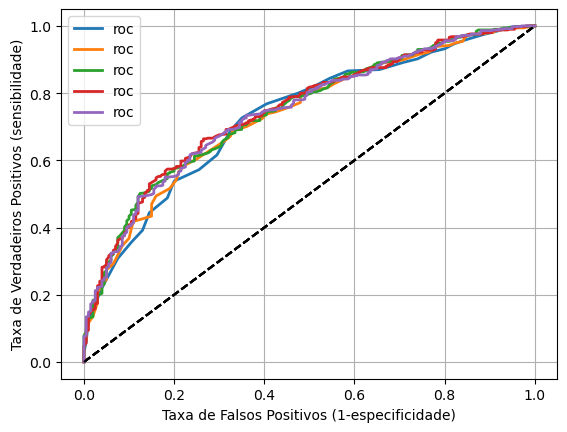

In [8]:
trees = [50, 100, 500, 750, 1000]
for t in trees:
        train_rf(t)